<a href="https://colab.research.google.com/github/BorisLouis/OpenCV_DeepLearning/blob/main/CIFAR100_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass

from tensorflow.keras.utils import to_categorical

block_plot = False

import ssl

In [2]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

    os.makedirs('models', exist_ok=True)

system_config()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


In [3]:
dataset_choice = {
    'cifar10': 1,
    'cifar100': 2
}

In [4]:
dataset = dataset_choice['cifar100']
print(f"Choosen dataset: {dataset}")

Choosen dataset: 2


In [5]:
if dataset == 1:
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
else:
    class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm']

In [6]:
def get_data(dataset=1):

    if dataset == 1:
        cifar10 = tf.keras.datasets.cifar10
        (train_images, train_labels), (valid_images, valid_labels) = cifar10.load_data()
        train_labels = train_labels.reshape(50000)
        valid_labels = valid_labels.reshape(10000)
    else:
        cifar100 = tf.keras.datasets.cifar100
        (train_images, train_labels), (valid_images, valid_labels) = cifar100.load_data()
        train_labels = train_labels.reshape(50000)
        valid_labels = valid_labels.reshape(10000)

    return (train_images, train_labels), (valid_images, valid_labels)

In [7]:
# Get the dataset.
(X_train_0, y_train_0), (X_valid_0, y_valid_0) = get_data(dataset)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


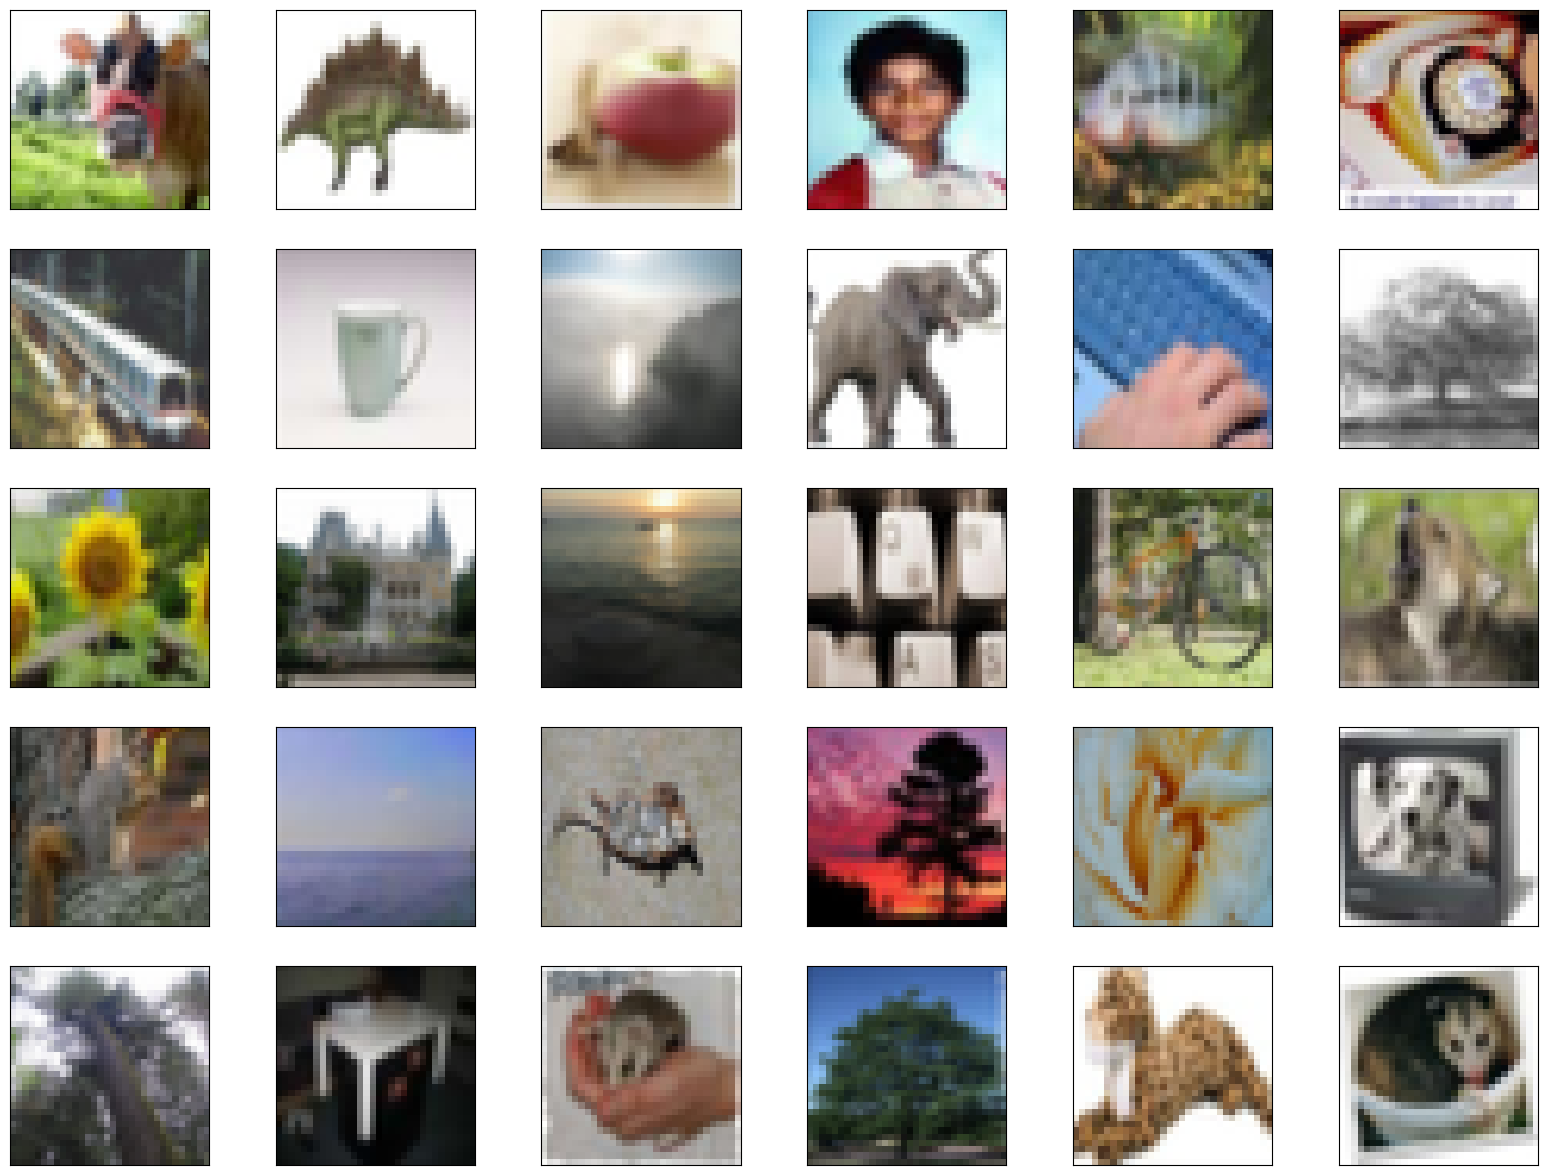

In [8]:
def display_sample_images(X):
    plt.figure(figsize=(20, 15))

    num_rows = 5
    num_cols = 6
    for idx in range(num_rows*num_cols):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[idx])

    plt.show(block=block_plot)

display_sample_images(X_train_0)

In [9]:
def get_mean_std_train_data(train_data):

  # Normalize to [0, 1] first, THEN calculate statistics
  train_data_normalized = train_data.astype(np.float32) / 255.0

  # Calculate mean and std per channel on normalized data
  mean = train_data_normalized.mean(axis=(0, 1, 2))
  std = train_data_normalized.std(axis=(0, 1, 2))

  print(f"Mean per channel: {mean}")
  print(f"Std per channel: {std}")
  return mean, std
mean, std = get_mean_std_train_data(X_train_0)

Mean per channel: [0.5070754  0.48655024 0.44091907]
Std per channel: [0.26733398 0.25643876 0.2761503 ]


In [10]:
def preprocess_dataset(train_set, valid_set, num_classes=3, seed=3):

    (X_train, y_train) = train_set
    (X_valid, y_valid) = valid_set

    X_train = X_train.astype(np.float32)
    X_valid = X_valid.astype(np.float32)

    mean, std = get_mean_std_train_data(X_train)

    # Changing range of pixel values from [0 - 255] to [0. - 1.0].
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    X_train = (X_train - mean) / std
    X_valid = (X_valid - mean) / std

    if len(X_train.shape) != 4:
        X_train = tf.expand_dims(X_train, axis=3)
        X_valid = tf.expand_dims(X_valid, axis=3)


    n_train = X_train.shape[0]
    n_valid = X_valid.shape[0]

    n_classes = len(np.unique(y_train))

    image_shape = X_train[0].shape

    print("There are {} training examples ".format(n_train))
    print("There are {} validation examples".format(n_valid))
    print("Image data shape is {}".format(image_shape))
    print("There are {} classes".format(n_classes))

     # Confirm number of classes present in the dataset matches the specified number of classes.
    assert num_classes == len(
        np.unique(y_train)
    ), "Number of classes present in the dataset does not match specified nuber of classes."

    print('There are {} classes'.format(num_classes))

    if len(y_train.shape) != 2:
        y_train = to_categorical(y_train, num_classes)
        y_valid = to_categorical(y_valid, num_classes)
    print(f"\n\nX_train: {X_train.shape}, Y_train: {y_train.shape}")
    print(f"X_validation: {X_valid.shape}, Y_valid: {y_valid.shape}")


    return (X_train, y_train), (X_valid, y_valid)

In [11]:
@dataclass(frozen=True)
class DatasetConfig:
    CHANNELS:   int = 3
    if dataset == 1:
        NUM_CLASSES: int = 10
    else:
        NUM_CLASSES: int = 100

dataset_config = DatasetConfig()

In [12]:
# Preprocess dataset.
((X_train, y_train),
 (X_valid, y_valid)) = preprocess_dataset((X_train_0, y_train_0),
                                          (X_valid_0, y_valid_0),
                                          num_classes=dataset_config.NUM_CLASSES,
                                          )

Mean per channel: [0.5070754  0.48655024 0.44091907]
Std per channel: [0.26733398 0.25643876 0.2761503 ]
There are 50000 training examples 
There are 10000 validation examples
Image data shape is (32, 32, 3)
There are 100 classes
There are 100 classes


X_train: (50000, 32, 32, 3), Y_train: (50000, 100)
X_validation: (10000, 32, 32, 3), Y_valid: (10000, 100)


In [13]:
is_training = True

@dataclass(frozen=True)
class TrainingConfig:
    ### DO NOT EDIT THESE
    BATCH_SIZE:       int = 32   # Amount of data to pass through the network at each forward-backward iteration.
    EPOCHS:           int = 1    # Number of times the whole dataset will be passed through the network.
    LEARNING_RATE:  float = 0.1  # The learning rate that is applied to the gradient during back-propagation.

    # Change the batch size, epochs, and learning rate here if you intend to do so.
    BATCH_SIZE:       int = 32   # Amount of data to pass through the network at each forward-backward iteration.
    EPOCHS:           int = 50    # Number of times the whole dataset will be passed through the network.
    LEARNING_RATE:  float = 0.005  # The learning rate that is applied to the gradient during back-propagation.

training_config = TrainingConfig()

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from keras.optimizers import Adam, SGD

def MyModel(input_shape=(32, 32, 3), num_classes=10, print_summary=True):

    # Input layer - CIFAR-100 images are 32x32x3
    inputs = Input(shape=(32, 32, 3))

    # Data augmentation layers (only active during training)
    x = RandomFlip("horizontal")(inputs)
    x = RandomRotation(0.1)(x)  # 10% rotation
    x = RandomTranslation(0.1, 0.1)(x)  # 10% shift
    x = RandomZoom(0.1)(x)  # 10% zoom

    # First convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Second convolutional block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Third convolutional block
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer - 100 classes for CIFAR-100
    outputs = Dense(100, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name='cifar100_cnn')

    if print_summary:
        print(model.summary())
    return model

In [15]:
# Initialize the CNN Model.
my_model = MyModel(num_classes=dataset_config.NUM_CLASSES,
                   print_summary=False,
                   )

In [16]:
model_summary = my_model.summary()
print(model_summary)

Model: "cifar100_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 32, 32, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 3,406,756 (13.00 MB)

 Trainable params: 3,403,428 (12.98 MB)

 Non-trainable params: 3,328 (13.00 KB)

None


In [17]:
if is_training:

    if dataset == 1:
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("models/cifar10_cnn_model.h5", monitor= "val_accuracy",
                                                       save_best_only=True, mode= "max")
    else:
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("models/cifar100_cnn_model.h5", monitor= "val_accuracy",
                                                       save_best_only=True, mode= "max")
    # Compile the model.
    my_model.compile(tf.keras.optimizers.SGD(learning_rate=training_config.LEARNING_RATE, momentum=0.9),
                 loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=["accuracy"],
                )

    # Train the model.
    training_results = my_model.fit(X_train,
                                    y_train,
                                    epochs=training_config.EPOCHS,
                                    batch_size=training_config.BATCH_SIZE,
                                    validation_data=(X_valid, y_valid),
                                    callbacks=[checkpoint_callback,]
                                    )


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0399 - loss: 4.8340

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.0399 - loss: 4.8337 - val_accuracy: 0.1334 - val_loss: 3.6453
Epoch 2/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1051 - loss: 3.8651

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.1051 - loss: 3.8650 - val_accuracy: 0.1986 - val_loss: 3.3125
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1443 - loss: 3.6008

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.1443 - loss: 3.6008 - val_accuracy: 0.2267 - val_loss: 3.1762
Epoch 4/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1710 - loss: 3.4304

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.1710 - loss: 3.4303 - val_accuracy: 0.2396 - val_loss: 3.1081
Epoch 5/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1942 - loss: 3.2909

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.1942 - loss: 3.2908 - val_accuracy: 0.2745 - val_loss: 2.9112
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2197 - loss: 3.1746

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.2197 - loss: 3.1746 - val_accuracy: 0.2886 - val_loss: 2.8154
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2371 - loss: 3.0658

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.2371 - loss: 3.0658 - val_accuracy: 0.3040 - val_loss: 2.7490
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.2509 - loss: 2.9828 - val_accuracy: 0.2968 - val_loss: 2.7958
Epoch 9/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2709 - loss: 2.8937

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.2709 - loss: 2.8937 - val_accuracy: 0.3524 - val_loss: 2.5078
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.2844 - loss: 2.8252 - val_accuracy: 0.3509 - val_loss: 2.5071
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2981 - loss: 2.7569

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.2981 - loss: 2.7569 - val_accuracy: 0.3658 - val_loss: 2.4279
Epoch 12/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3132 - loss: 2.6991

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3132 - loss: 2.6991 - val_accuracy: 0.3874 - val_loss: 2.3637
Epoch 13/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3236 - loss: 2.6355 - val_accuracy: 0.3679 - val_loss: 2.4391
Epoch 14/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3320 - loss: 2.5904

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3320 - loss: 2.5904 - val_accuracy: 0.3990 - val_loss: 2.2613
Epoch 15/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3489 - loss: 2.5351

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.3489 - loss: 2.5351 - val_accuracy: 0.4208 - val_loss: 2.1895
Epoch 16/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3525 - loss: 2.4883

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3525 - loss: 2.4883 - val_accuracy: 0.4261 - val_loss: 2.1839
Epoch 17/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3647 - loss: 2.4466 - val_accuracy: 0.4098 - val_loss: 2.2695
Epoch 18/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3767 - loss: 2.3974 - val_accuracy: 0.4246 - val_loss: 2.1747
Epoch 19/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3784 - loss: 2.3585

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3784 - loss: 2.3585 - val_accuracy: 0.4524 - val_loss: 2.0456
Epoch 20/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3870 - loss: 2.3303

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3870 - loss: 2.3303 - val_accuracy: 0.4582 - val_loss: 2.0304
Epoch 21/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4026 - loss: 2.2818 - val_accuracy: 0.4512 - val_loss: 2.0728
Epoch 22/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.4048 - loss: 2.2678 - val_accuracy: 0.4526 - val_loss: 2.0481
Epoch 23/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4150 - loss: 2.2296

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4150 - loss: 2.2296 - val_accuracy: 0.4636 - val_loss: 1.9970
Epoch 24/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4117 - loss: 2.2124

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.4117 - loss: 2.2124 - val_accuracy: 0.4725 - val_loss: 1.9925
Epoch 25/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4251 - loss: 2.1625

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4251 - loss: 2.1625 - val_accuracy: 0.4871 - val_loss: 1.8753
Epoch 26/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4358 - loss: 2.1342

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4358 - loss: 2.1342 - val_accuracy: 0.4919 - val_loss: 1.9014
Epoch 27/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4377 - loss: 2.1042

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4377 - loss: 2.1042 - val_accuracy: 0.5000 - val_loss: 1.8708
Epoch 28/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4414 - loss: 2.0823

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4414 - loss: 2.0823 - val_accuracy: 0.5097 - val_loss: 1.8214
Epoch 29/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.4443 - loss: 2.0668 - val_accuracy: 0.5058 - val_loss: 1.8484
Epoch 30/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4498 - loss: 2.0584

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4498 - loss: 2.0584 - val_accuracy: 0.5117 - val_loss: 1.8174
Epoch 31/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4527 - loss: 2.0335

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4527 - loss: 2.0335 - val_accuracy: 0.5181 - val_loss: 1.7888
Epoch 32/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4645 - loss: 1.9942

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4645 - loss: 1.9943 - val_accuracy: 0.5315 - val_loss: 1.7368
Epoch 33/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4677 - loss: 1.9809 - val_accuracy: 0.5203 - val_loss: 1.7988
Epoch 34/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4664 - loss: 1.9781 - val_accuracy: 0.5274 - val_loss: 1.7330
Epoch 35/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4732 - loss: 1.9515 - val_accuracy: 0.5221 - val_loss: 1.7790
Epoch 36/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4817 - loss: 1.9286 - val_accuracy: 0.5267 - val_loss: 1.7599
Epoch 37/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4837 - loss: 1.9198

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4837 - loss: 1.9198 - val_accuracy: 0.5401 - val_loss: 1.6870
Epoch 38/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4855 - loss: 1.9070 - val_accuracy: 0.5370 - val_loss: 1.7060
Epoch 39/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4926 - loss: 1.8666

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4926 - loss: 1.8666 - val_accuracy: 0.5456 - val_loss: 1.6809
Epoch 40/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4936 - loss: 1.8700

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4936 - loss: 1.8700 - val_accuracy: 0.5470 - val_loss: 1.6523
Epoch 41/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4990 - loss: 1.8495

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4990 - loss: 1.8496 - val_accuracy: 0.5530 - val_loss: 1.6531
Epoch 42/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4979 - loss: 1.8452 - val_accuracy: 0.5439 - val_loss: 1.6970
Epoch 43/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5020 - loss: 1.8321 - val_accuracy: 0.5471 - val_loss: 1.6888
Epoch 44/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5102 - loss: 1.8058 - val_accuracy: 0.5355 - val_loss: 1.7336
Epoch 45/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5066 - loss: 1.8197

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5066 - loss: 1.8197 - val_accuracy: 0.5538 - val_loss: 1.6476
Epoch 46/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5120 - loss: 1.7978

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5120 - loss: 1.7978 - val_accuracy: 0.5627 - val_loss: 1.6231
Epoch 47/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5138 - loss: 1.7814 - val_accuracy: 0.5587 - val_loss: 1.6130
Epoch 48/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5193 - loss: 1.7602 - val_accuracy: 0.5491 - val_loss: 1.6665
Epoch 49/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5242 - loss: 1.7544 - val_accuracy: 0.5509 - val_loss: 1.6719
Epoch 50/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.5254 - loss: 1.7460 - val_accuracy: 0.5454 - val_loss: 1.7177


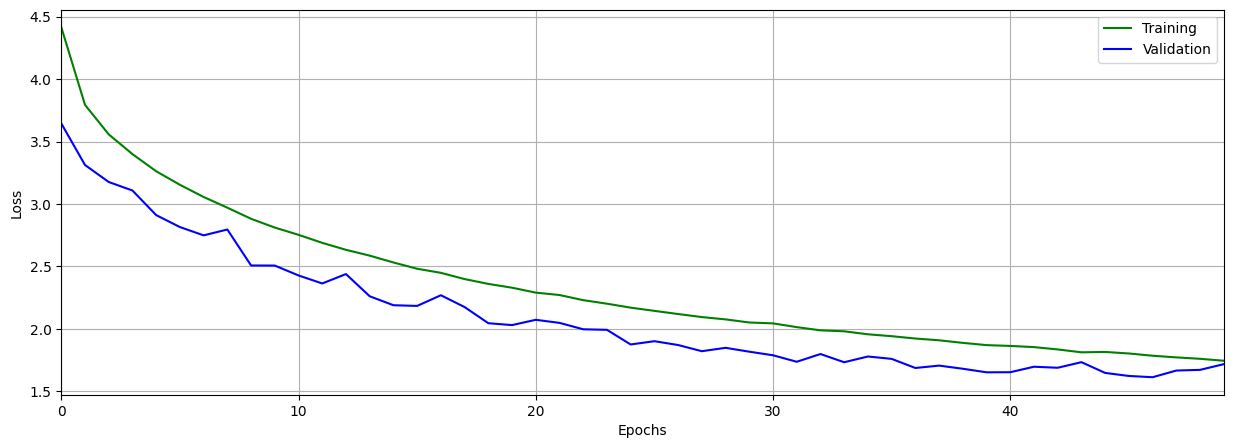

In [18]:
# Plot loss.
if is_training:

    plt.figure(figsize=[15,5])

    # Loss plots.
    plt.plot(training_results.history['loss'], 'g')
    plt.plot(training_results.history['val_loss'], 'b')

    plt.xlim([0.0, training_config.EPOCHS-1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend(['Training', 'Validation'], loc='upper right');
    plt.grid(True)
    plt.show(block=block_plot)

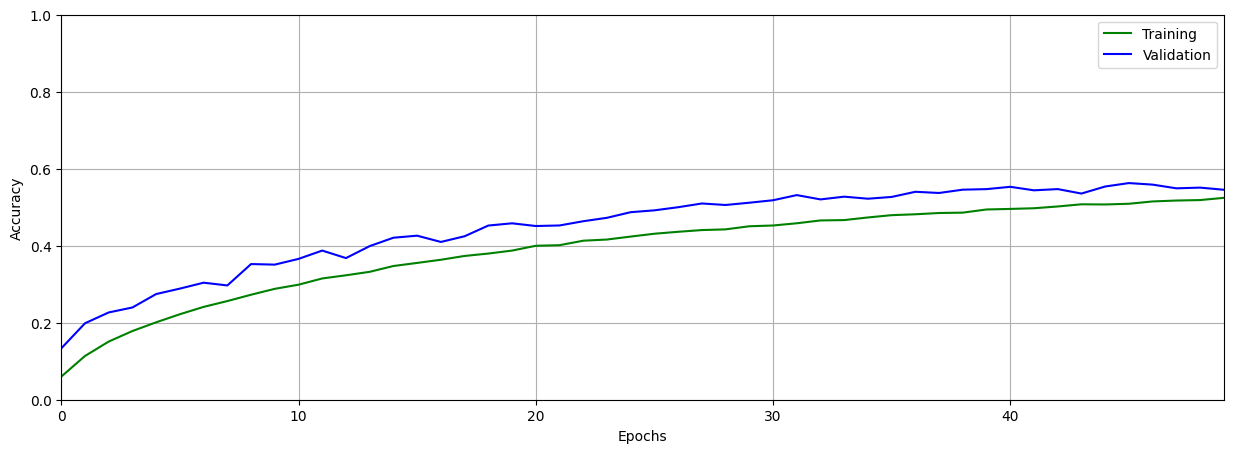

In [19]:
# Plot accuracy.
if is_training:

    plt.figure(figsize=[15,5])

    # Loss plots.
    plt.plot(training_results.history['accuracy'], 'g')
    plt.plot(training_results.history['val_accuracy'], 'b')

    plt.xlim([0.0, training_config.EPOCHS-1])
    plt.ylim([0.0, 1])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.legend(['Training', 'Validation'], loc='upper right');
    plt.grid(True)
    plt.show(block=block_plot)

In [20]:
# Load the saved model.
if dataset == 1:
    cnn_model = tf.keras.models.load_model('models/cifar10_cnn_model.h5')
else:
    cnn_model = tf.keras.models.load_model('models/cifar100_cnn_model.h5')

In [21]:
# Load the saved model.
if dataset == 1:
    cnn_model = tf.keras.models.load_model('models/cifar10_cnn_model.h5')
else:
    cnn_model = tf.keras.models.load_model('models/cifar100_cnn_model.h5')

In [22]:
# Preprocess dataset.
((_, _),(X_valid, y_valid),) = preprocess_dataset((X_train_0, y_train_0),
                                                (X_valid_0, y_valid_0),

                                                num_classes=dataset_config.NUM_CLASSES,
                                               )

predictions = cnn_model.evaluate(X_valid, y_valid)
print(f"Validation accuracy: {predictions[1]*100:.3f}%")

Mean per channel: [0.5070754  0.48655024 0.44091907]
Std per channel: [0.26733398 0.25643876 0.2761503 ]
There are 50000 training examples 
There are 10000 validation examples
Image data shape is (32, 32, 3)
There are 100 classes
There are 100 classes


X_train: (50000, 32, 32, 3), Y_train: (50000, 100)
X_validation: (10000, 32, 32, 3), Y_valid: (10000, 100)
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5624 - loss: 1.6350
Validation accuracy: 56.270%


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


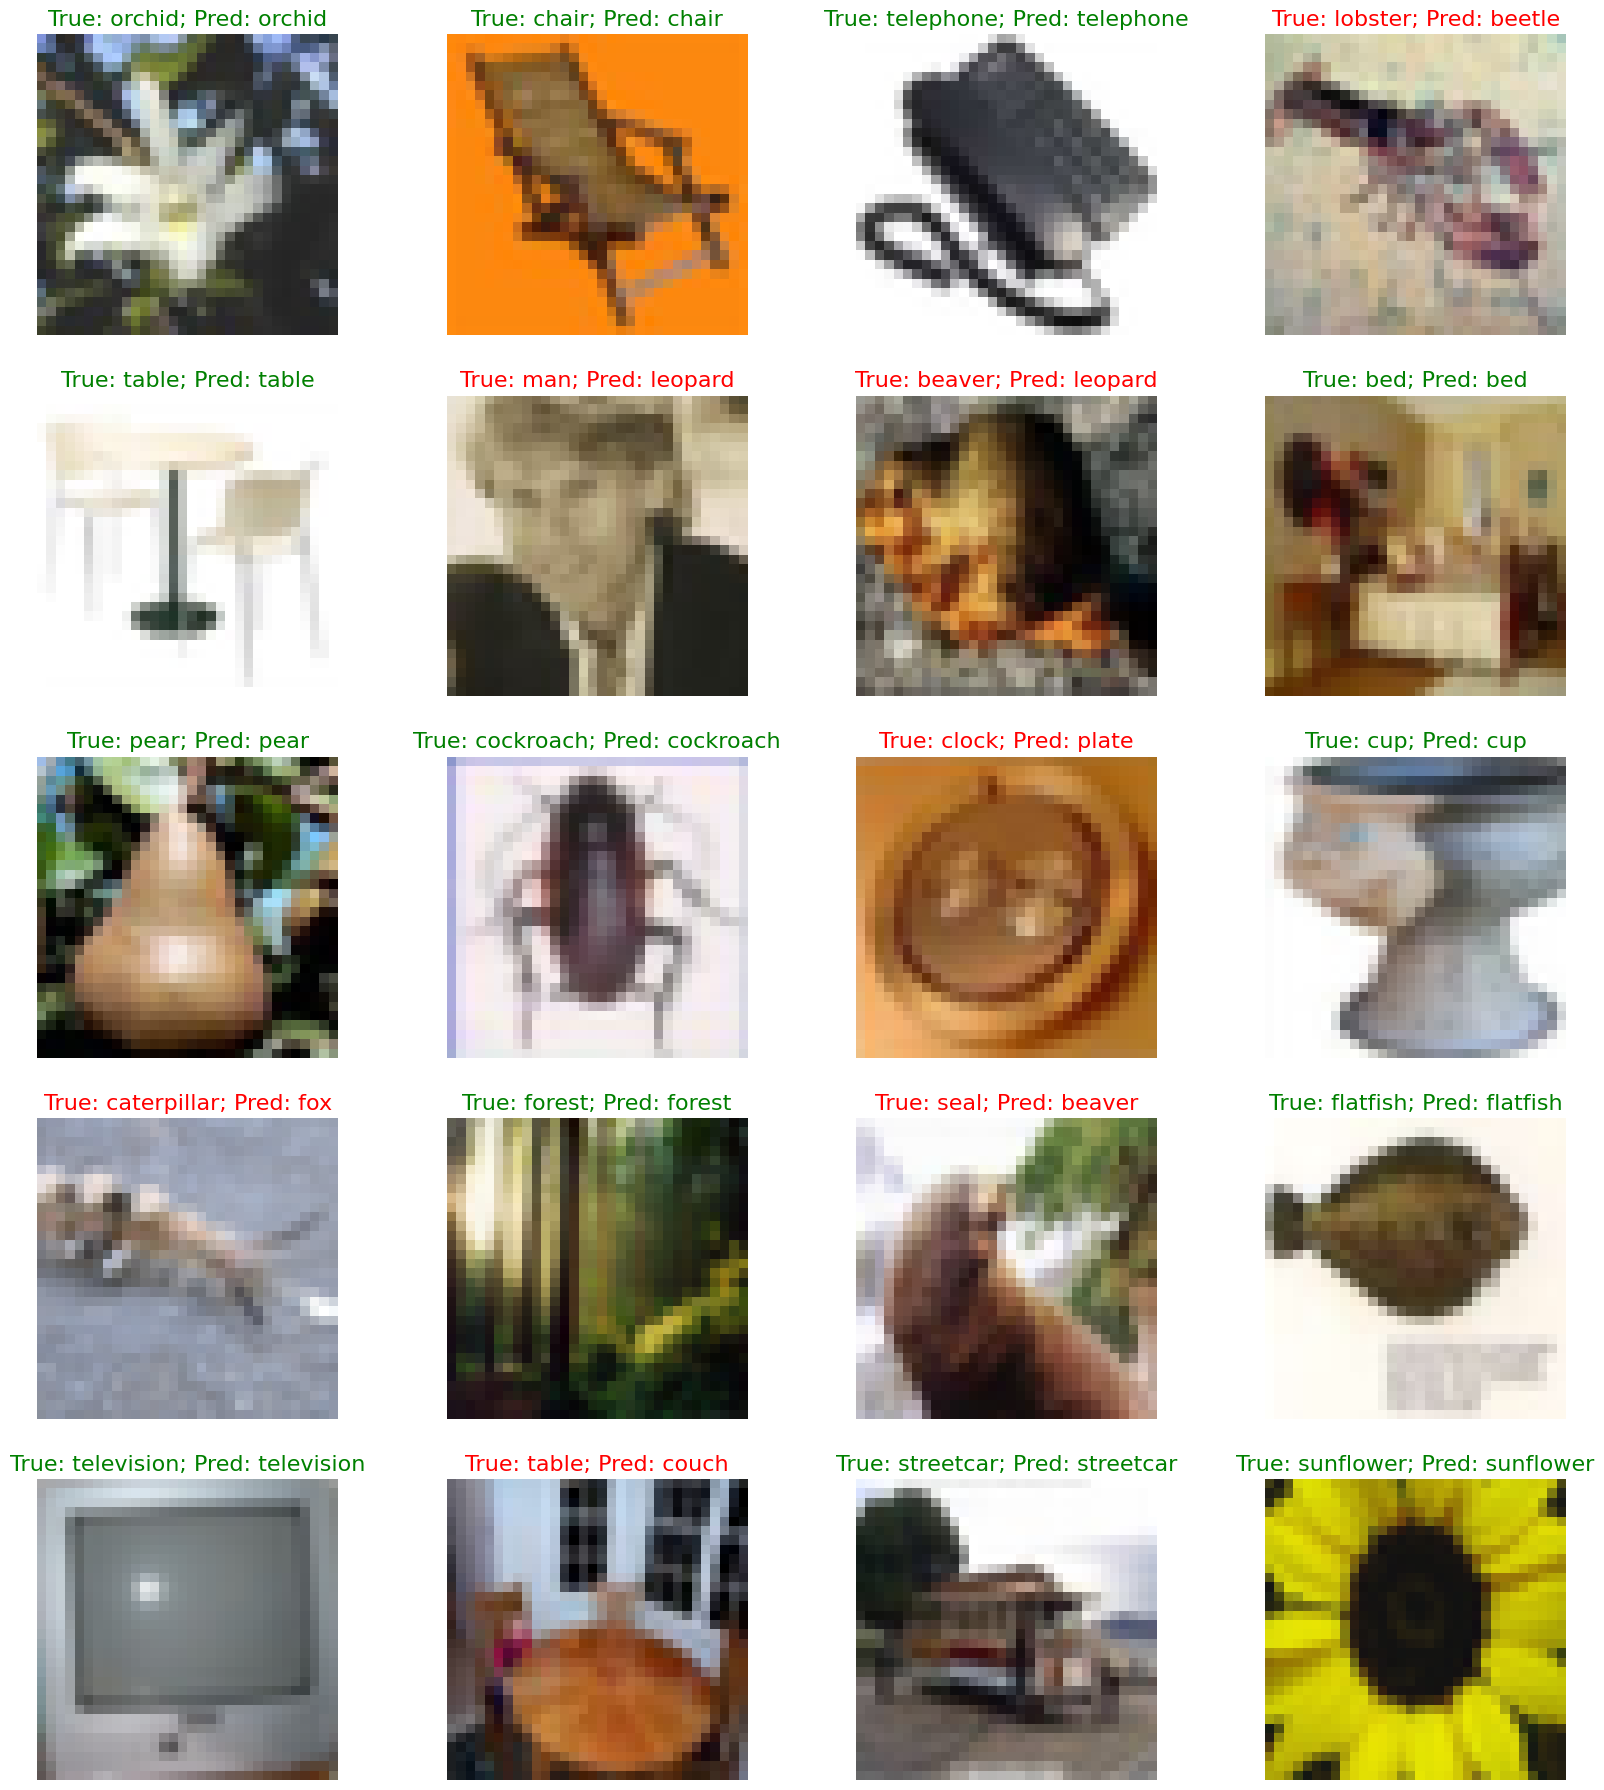

In [23]:
y_pred = cnn_model.predict(X_valid)

plt.figure(figsize=(20, 18))
num_rows = 5
num_cols = 4

for idx in range(num_rows*num_cols):

    random_sample = np.random.randint(0, 10000, 1)[0]
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.axis('off')
    plt.imshow(X_valid_0[random_sample])
    gt_class = class_names[int(y_valid_0[random_sample])]
    pred_class = class_names[np.argmax(y_pred[random_sample])]

    title = 'True: ' + str(gt_class) + '; Pred: ' + str(pred_class)
    title_obj = plt.title(title, fontdict={'fontsize':16})

    if gt_class == pred_class:
        plt.setp(title_obj, color='g')
    else:
        plt.setp(title_obj, color='r')

    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=1.0, wspace=0.1, hspace=0.2)

plt.show(block=block_plot)